# Use Tempered SMC to Improve Exploration of MCMC Methods.
Multimodal distributions are typically hard to sample from, in particular using energy based methods such as HMC,
as you need high energy levels to escape a potential well.

Tempered SMC helps with this by considering a sequence of
distributions:

$$
p_{\lambda_k}(x) \propto p_0(x) \exp(-\lambda_k V(x))
$$

where the tempering parameter $\lambda_k$ takes increasing values between $0$ and $1$. Tempered SMC will also particularly shine when the MCMC step
is not well calibrated (too small step size, etc) like in the example below.

## Imports

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax.scipy.stats import multivariate_normal

jax.config.update("jax_platform_name", "cpu")

import blackjax
import blackjax.smc.resampling as resampling

## Sampling From a Bimodal Potential

### Experimental Setup

We consider a prior distribution

$$
p_0(x) = \mathcal{N}(x \mid 0, 1)
$$

and a potential function

$$
V(x) = (x^2 - 1)^2
$$

This corresponds to the following distribution. We plot the resulting tempered density for 5 different values of $\lambda_k$ : from $\lambda_k =1$ which correponds to the original density to $\lambda_k=0$. The lower the value of $\lambda_k$ the easier it is for the sampler to jump between the modes of the posterior density.

In [2]:
def V(x):
    return 5 * jnp.square(jnp.sum(x**2) - 1)


def prior_log_prob(x):
    d = x.shape[0]
    return multivariate_normal.logpdf(x, jnp.zeros((d,)), jnp.eye(d))


linspace = jnp.linspace(-2, 2, 5000).reshape(-1, 1)
lambdas = jnp.linspace(0.0, 1.0, 5)
prior_logvals = jnp.vectorize(prior_log_prob, signature="(d)->()")(linspace)
potential_vals = jnp.vectorize(V, signature="(d)->()")(linspace)
log_res = prior_logvals.reshape(1, -1) - jnp.expand_dims(
    lambdas, 1
) * potential_vals.reshape(1, -1)

density = jnp.exp(log_res)
normalizing_factor = jnp.sum(density, axis=1, keepdims=True) * (
    linspace[1] - linspace[0]
)
density /= normalizing_factor

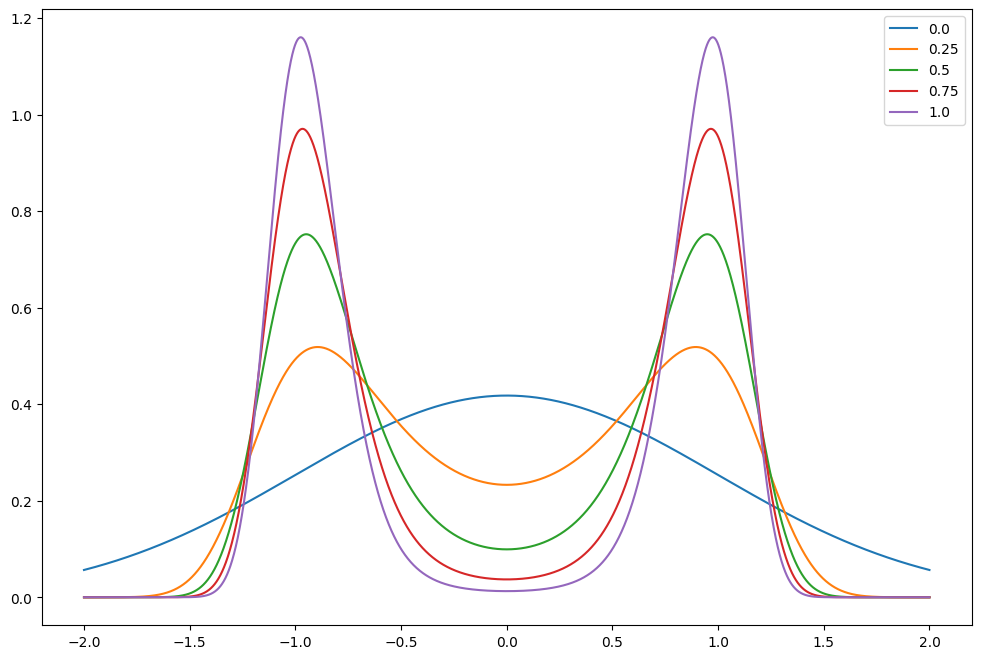

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(linspace.squeeze(), density.T)
ax.legend(list(lambdas))

In [4]:
def inference_loop(rng_key, mcmc_kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, k):
        state, _ = mcmc_kernel(k, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states


def full_logdensity(x):
    return -V(x) + prior_log_prob(x)


inv_mass_matrix = jnp.eye(1)
n_samples = 10_000

### Sample with HMC

We first try to sample from the posterior density using an HMC kernel.

In [5]:
%%time

key = jax.random.PRNGKey(42)

hmc_parameters = dict(
    step_size=1e-4, inverse_mass_matrix=inv_mass_matrix, num_integration_steps=50
)

hmc = blackjax.hmc(full_logdensity, **hmc_parameters)
hmc_state = hmc.init(jnp.ones((1,)))
hmc_samples = inference_loop(key, hmc.step, hmc_state, n_samples)

CPU times: user 1.5 s, sys: 24.8 ms, total: 1.52 s
Wall time: 1.52 s


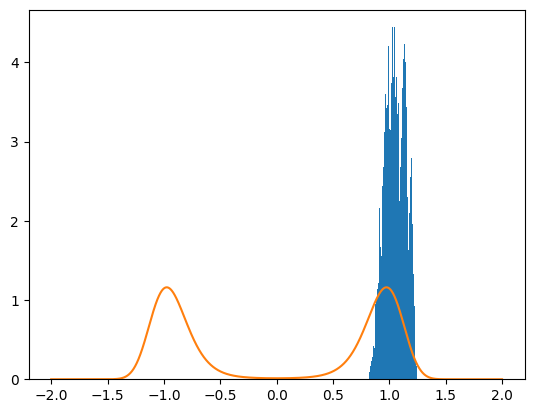

In [6]:
samples = np.array(hmc_samples.position[:, 0])
_ = plt.hist(samples, bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])

### Sample with NUTS

We now use a NUTS kernel.

In [7]:
%%time

nuts_parameters = dict(step_size=1e-4, inverse_mass_matrix=inv_mass_matrix)

nuts = blackjax.nuts(full_logdensity, **nuts_parameters)
nuts_state = nuts.init(jnp.ones((1,)))
nuts_samples = inference_loop(key, nuts.step, nuts_state, n_samples)

CPU times: user 8.02 s, sys: 9.31 ms, total: 8.03 s
Wall time: 8.02 s


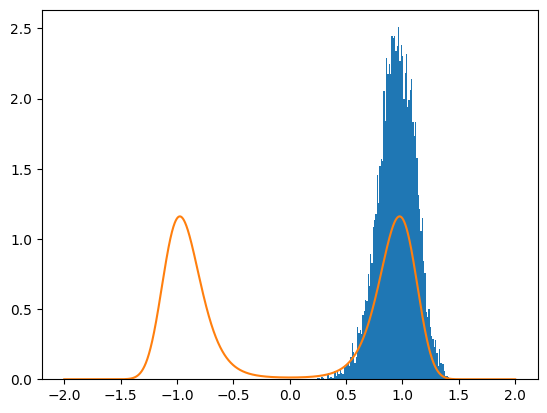

In [8]:
samples = np.array(nuts_samples.position[:, 0])
_ = plt.hist(samples, bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])

## Tempered SMC with HMC Kernel

We now use the adaptive tempered SMC algorithm with an HMC kernel. We only take one HMC step before resampling. The algorithm is run until $\lambda_k$ crosses the $\lambda_k = 1$ limit.

In [9]:
def smc_inference_loop(rng_key, smc_kernel, initial_state):
    """Run the temepered SMC algorithm.

    We run the adaptive algorithm until the tempering parameter lambda reaches the value
    lambda=1.

    """

    def cond(carry):
        i, state, _k = carry
        return state.lmbda < 1

    def one_step(carry):
        i, state, k = carry
        k, subk = jax.random.split(k, 2)
        state, _ = smc_kernel(subk, state)
        return i + 1, state, k

    n_iter, final_state, _ = jax.lax.while_loop(
        cond, one_step, (0, initial_state, rng_key)
    )

    return n_iter, final_state

In [10]:
%%time

loglikelihood = lambda x: -V(x)

hmc_parameters = dict(
    step_size=1e-4, inverse_mass_matrix=inv_mass_matrix, num_integration_steps=1
)

tempered = blackjax.adaptive_tempered_smc(
    prior_log_prob,
    loglikelihood,
    blackjax.hmc.kernel(),
    blackjax.hmc.init,
    hmc_parameters,
    resampling.systematic,
    0.5,
    num_mcmc_steps=1,
)

initial_smc_state = jax.random.multivariate_normal(
    jax.random.PRNGKey(0), jnp.zeros([1]), jnp.eye(1), (n_samples,)
)
initial_smc_state = tempered.init(initial_smc_state)

n_iter, smc_samples = smc_inference_loop(key, tempered.step, initial_smc_state)
print("Number of steps in the adaptive algorithm: ", n_iter.item())

Number of steps in the adaptive algorithm:  12
CPU times: user 2.94 s, sys: 60 ms, total: 3 s
Wall time: 2.93 s


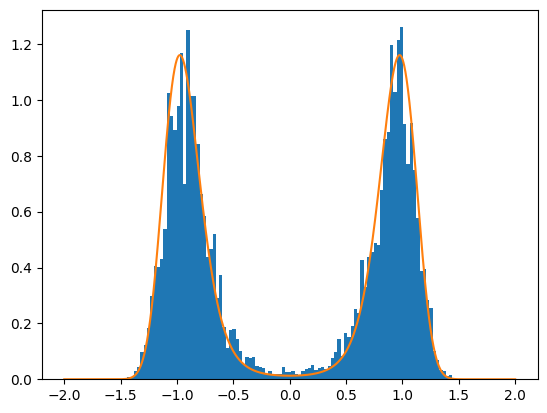

In [11]:
samples = np.array(smc_samples.particles[:, 0])
_ = plt.hist(samples, bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])

## Sampling from the Rastrigin Potential

### Experimental Setup

We consider a prior distribution $p_0(x) = \mathcal{N}(x \mid 0_2, 2 I_2)$ and we want to sample from a Rastrigin type potential function $V(x) = -2 A + \sum_{i=1}^2x_i^2 - A  \cos(2 \pi x_i)$ where we choose $A=10$. These potential functions are known to be particularly hard to sample.

We plot the resulting tempered density for 5 different values of $\lambda_k$: from $\lambda_k =1$ which correponds to the original density to $\lambda_k=0$. The lower the value of $\lambda_k$ the easier it is to sampler from the posterior log-density.

In [12]:
def prior_log_prob(x):
    d = x.shape[0]
    return multivariate_normal.logpdf(x, jnp.zeros((d,)), 2 * jnp.eye(d))


def V(x):
    d = x.shape[-1]
    res = -10 * d + jnp.sum(x**2 - 10 * jnp.cos(2 * jnp.pi * x), -1)
    return res


linspace = jnp.linspace(-5, 5, 5000).reshape(-1, 1)
lambdas = jnp.linspace(0.0, 1.0, 5)
potential_vals = jnp.vectorize(V, signature="(d)->()")(linspace)
log_res = jnp.expand_dims(lambdas, 1) * potential_vals.reshape(1, -1)

density = jnp.exp(-log_res)
normalizing_factor = jnp.sum(density, axis=1, keepdims=True) * (
    linspace[1] - linspace[0]
)
density /= normalizing_factor

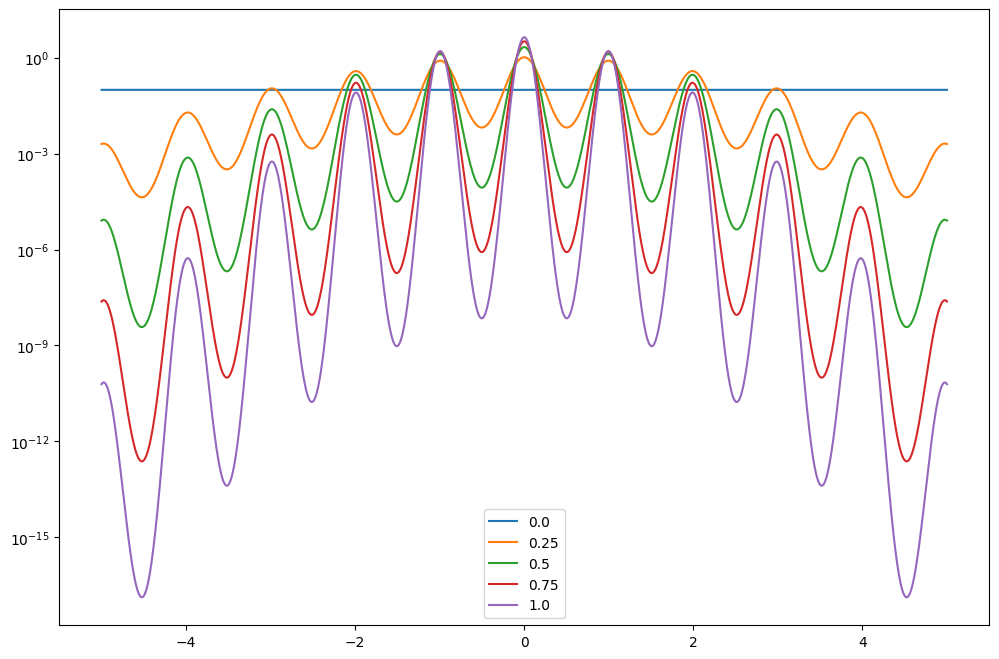

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.semilogy(linspace.squeeze(), density.T)
ax.legend(list(lambdas))

In [14]:
def inference_loop(rng_key, mcmc_kernel, initial_state, num_samples):
    def one_step(state, k):
        state, _ = mcmc_kernel(k, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states


inv_mass_matrix = jnp.eye(1)
n_samples = 1_000

### HMC Sampler

We first try to sample from the posterior density using an HMC kernel.

In [15]:
%%time

key = jax.random.PRNGKey(42)

loglikelihood = lambda x: -V(x)

hmc_parameters = dict(
    step_size=1e-2, inverse_mass_matrix=inv_mass_matrix, num_integration_steps=50
)

hmc = blackjax.hmc(full_logdensity, **hmc_parameters)
hmc_state = hmc.init(jnp.ones((1,)))
hmc_samples = inference_loop(key, hmc.step, hmc_state, n_samples)

CPU times: user 815 ms, sys: 8.01 ms, total: 823 ms
Wall time: 819 ms


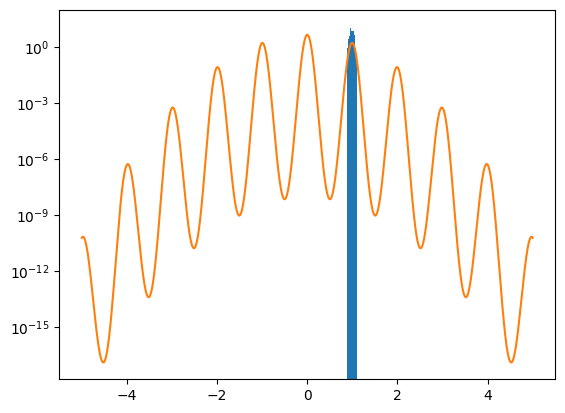

In [16]:
samples = np.array(hmc_samples.position[:, 0])
_ = plt.hist(samples, bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])
_ = plt.yscale("log")

### NUTS Sampler

We do the same using a NUTS kernel.

In [17]:
%%time

nuts_parameters = dict(step_size=1e-2, inverse_mass_matrix=inv_mass_matrix)

nuts = blackjax.nuts(full_logdensity, **nuts_parameters)
nuts_state = nuts.init(jnp.ones((1,)))
nuts_samples = inference_loop(key, nuts.step, nuts_state, n_samples)

CPU times: user 1.55 s, sys: 27.9 ms, total: 1.58 s
Wall time: 1.57 s


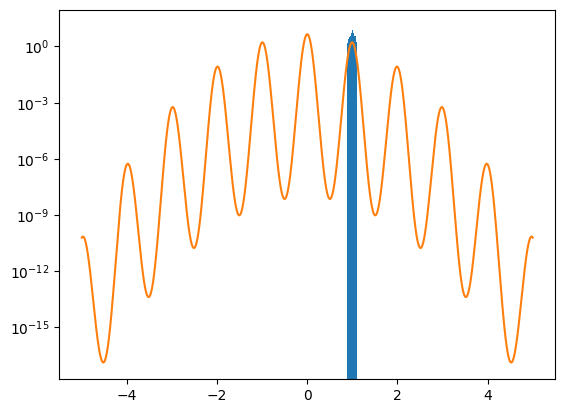

In [18]:
samples = np.array(nuts_samples.position[:, 0])
_ = plt.hist(samples, bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])
_ = plt.yscale("log")

### Tempered SMC with HMC Kernel

We now use the adaptive tempered SMC algorithm with an HMC kernel. We only take one HMC step before resampling. The algorithm is run until $\lambda_k$ crosses the $\lambda_k = 1$ limit.
We correct the bias introduced by the (arbitrary) prior.

In [19]:
%%time

loglikelihood = lambda x: -V(x)

hmc_parameters = dict(
    step_size=1e-2, inverse_mass_matrix=inv_mass_matrix, num_integration_steps=100
)

tempered = blackjax.adaptive_tempered_smc(
    prior_log_prob,
    loglikelihood,
    blackjax.hmc,
    hmc_parameters,
    resampling.systematic,
    0.75,
    mcmc_iter=1,
)

initial_smc_state = jax.random.multivariate_normal(
    jax.random.PRNGKey(0), jnp.zeros([1]), jnp.eye(1), (n_samples,)
)
initial_smc_state = tempered.init(initial_smc_state)

n_iter, smc_samples = smc_inference_loop(key, tempered.step, initial_smc_state)
print("Number of steps in the adaptive algorithm: ", n_iter.item())

TypeError: __new__() got an unexpected keyword argument 'mcmc_iter'

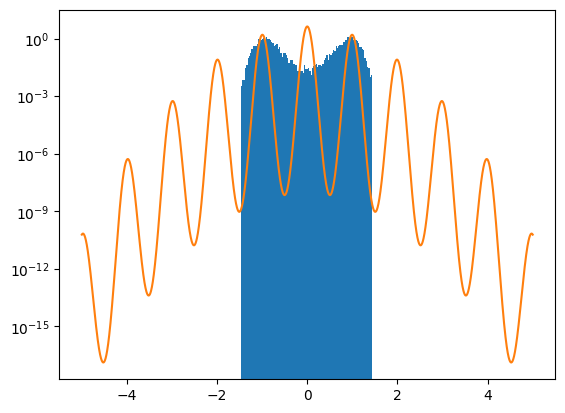

In [20]:
samples = np.array(smc_samples.particles[:, 0])
_ = plt.hist(samples, bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])
_ = plt.yscale("log")

The tempered SMC algorithm with the HMC kernel clearly outperfoms the HMC and NUTS kernels alone.